In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer

In [2]:
df=pd.read_excel('dataset_filledsupplier_currency_orderday.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24621 entries, 0 to 24620
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   청구서번호        24621 non-null  object 
 1   No.          24621 non-null  int64  
 2   Subject      24599 non-null  object 
 3   Machinery    24621 non-null  object 
 4   Assembly     24621 non-null  object 
 5   청구품목         24621 non-null  object 
 6   Unnamed: 6   0 non-null      float64
 7   Part No.1    24602 non-null  object 
 8   Part No.2    3592 non-null   object 
 9   청구량          24517 non-null  float64
 10  견적           24171 non-null  object 
 11  견적수량         24517 non-null  float64
 12  견적화폐         24621 non-null  object 
 13  견적단가         24621 non-null  float64
 14  발주번호         24621 non-null  object 
 15  발주처          24621 non-null  object 
 16  발주           24621 non-null  object 
 17  발주수량         24621 non-null  int64  
 18  발주금액         24621 non-null  float64
 19  D/T 

In [4]:
missing_conditions = df[
    df['발주'].notnull() &  # 발주 일자는 비어있지 않음
    df['미입고 기간'].isnull() &  # 미입고 기간은 비어있음
    df['창고입고'].isnull() & # 창고 입고도 비어있음
    df['선박입고'].isnull()  # 선박 입고도 비어있음

]

print(f"발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: {len(missing_conditions)}개")
# 해당 조건의 행 삭제
df = df.drop(missing_conditions.index)

print(f"삭제된 행의 개수: {len(missing_conditions)}개")
print(f"남은 데이터프레임의 크기: {df.shape}")

발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: 1699개
삭제된 행의 개수: 1699개
남은 데이터프레임의 크기: (22922, 32)


In [5]:
#미입고기간으로 처리.
missing_both = df[df['창고입고'].isnull() & df['미입고 기간'].notnull()]

print(f"창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : {len(missing_both)}개")

창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : 1620개


# 리드타임 계산

> 1. 발주와 입고가 같은 경우 리드타임을 1로 설정
> 2. 발주 수량과 입고 수량이 같은 경우, 일반 계산으로 기본타입

In [82]:
df['발주']=pd.to_datetime(df['발주'], errors='coerce')
df['창고입고']=pd.to_datetime(df['창고입고'], errors='coerce')

df['리드타임']=(df['창고입고'] - df['발주']).dt.days
df['리드타임']=df['리드타임'].apply(lambda x:1 if x == 0 else x)

print(df[['발주', '창고입고', '리드타임']].tail(10))

              발주       창고입고  리드타임
24594 2022-03-31 2022-04-21  21.0
24595 2022-03-31 2022-04-21  21.0
24596 2022-04-06 2022-07-03  88.0
24597 2022-04-06 2022-07-03  88.0
24598 2022-04-06 2022-07-03  88.0
24599 2022-04-06 2022-07-03  88.0
24600 2022-04-06 2022-07-03  88.0
24601 2022-04-06 2022-07-03  88.0
24602 2022-04-06 2022-07-03  88.0
24603 2022-04-06        NaT   NaN


In [12]:
print(df['리드타임'].notnull().sum(),df['리드타임'].isnull().sum())

21302 1620


# 다중 출력 모델
### 리드타임 예측 (회귀) / 미입고 기간 예측 (분류) 
1. 텍스트 칼럼 결합 및 BERT 임베딩
2. ( 수치형 데이터(견적단가 및 발주량) Scaling )
3. 범주형 데이터(견적화폐) onehotEncoding
4. BERT 임베딩 유사도 => 모델의 입력, 2.3데이터 결합 => 리드타임 OR 미입고 기간 예측

### 전처리

In [13]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[^\w\s\*/\-\+.,#&]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b(사용금지|사)\b', '', text, flags=re.IGNORECASE)
    text = text.strip()
    return text

def clean_supplier_name(name):
    name = name.lower()
    name = re.sub(r'coporation|coropration|coproration|corporration', 'corporation', name)
    name = re.sub(r'\(사용금지\)', '', name)
    name = re.sub(r'u\.s\.a', '_usa', name)
    name = re.sub(r'\.', '', name)
    suffixes = r'(corporation|corp|company|co|incorporated|inc|limited|ltd|상사|공사|엔지니어링|주식회사|주|gmbh|pte ltd|llc)'
    name = re.sub(suffixes, '', name, flags=re.IGNORECASE)
    name = re.sub(r'[^\w\s-]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

In [14]:
# 텍스트 컬럼 리스트
text_columns = ['Machinery', 'Assembly', '청구품목', 'Part No.1', '발주처']

for col in text_columns:
    df[col] = df[col].astype(str)
df['cleaned_machinery'] = df['Machinery'].apply(preprocess_text)
df['cleaned_assembly'] = df['Assembly'].apply(preprocess_text)
df['cleaned_item'] = df['청구품목'].apply(preprocess_text)
df['cleaned_supplier'] = df['발주처'].apply(clean_supplier_name)

df['combined_text'] = (
    df['cleaned_machinery'].fillna('') + " " +
    df['cleaned_assembly'].fillna('') + " " +
    df['cleaned_item'].fillna('') + " " +
    df['Part No.1'].fillna('') + " " +
    df['cleaned_supplier'].fillna('')
)

In [63]:
# 최종 데이터프레임 선택
final_df = df[['Machinery', 'Assembly', '청구품목', 'Part No.1', '발주처', '견적화폐', '발주',
               '발주수량', '발주금액', '미입고 기간', '창고입고', '리드타임', 'combined_text']].copy()

# 최종 데이터프레임 확인
print(final_df.shape)
print(final_df.head())

(22922, 13)
                          Machinery       Assembly  \
0    CARGO BOOM VANG BLOCK (STBD 하)          BLOCK   
1  SPANISH BOOM VANG BLOCK (PORT 상)          BLOCK   
2                       PURSE BLOCK      TOW BLOCK   
3                       MAIN ENGINE  POWER PACK AS   
4                       MAIN ENGINE  POWER PACK AS   

                                               청구품목               Part No.1  \
0  MCKISSICK CONSTRUCTION BLOCKS (WIRE SIZE : 5/8")                C15S10BS   
1  MCKISSICK CONSTRUCTION BLOCKS (WIRE SIZE : 5/8")                C15D10BS   
2                            WESTEC 20TON TOW BLOCK  WESTEC 20TON TOW BLOCK   
3                        GE POWER PACK FORK - E7(B)                40028340   
4                        GE POWER PACK FORK - E7(B)                40028340   

                         발주처 견적화폐         발주  발주수량          발주금액 미입고 기간  \
0  MATSUI(U.S.A) COROPRATION  USD 2019-01-11     2  2.288732e+06    NaN   
1  MATSUI(U.S.A) COROPRATION  USD 2019

### 데이터 분할

In [50]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, TensorDataset 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [51]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

C:\Users\User\anaconda3\envs\ship\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [52]:
def encode_data(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

In [53]:
def get_embeddings_batchwise(encodings, model, batch_size=16):
    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], encodings['token_type_ids'])
    dataloader = DataLoader(dataset, batch_size=batch_size)

    all_embeddings = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, token_type_ids = [t.to(device) for t in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            all_embeddings.append(outputs.pooler_output.cpu())

    return torch.cat(all_embeddings, dim=0)

### 발주일자가 창고입고보다 앞선 날짜라 - 값 나오는 애들 drop

In [64]:
negative_lead_time = final_df[final_df['리드타임'] < 0]
print(negative_lead_time[['발주', '창고입고', '리드타임', '청구품목', '견적화폐']]) 

              발주       창고입고  리드타임                               청구품목 견적화폐
2090  2020-01-08 2020-01-06  -2.0             MAIN ENGINE SYSTEM OIL  KRW
2091  2020-01-08 2020-01-06  -2.0       REFRIGERATION COMPRESSOR OIL  KRW
2327  2019-10-22 2019-10-19  -3.0                      FLEXIBLE HOSE  JPY
2328  2019-10-22 2019-10-19  -3.0  SEAL KIT FOR HA4VSO250DP HYD PUMP  JPY
2329  2019-10-22 2019-10-19  -3.0                      RETURN FILTER  JPY
...          ...        ...   ...                                ...  ...
20449 2021-11-29 2021-11-22  -7.0  FILTER ELEMENT WITH VITON O-RINGS  KRW
20461 2021-12-15 2021-12-14  -1.0                 OIL COOLER & LINES  KRW
21527 2021-12-01 2021-11-22  -9.0                         CONT GP -E  KRW
23656 2022-04-19 2022-04-09 -10.0                            BATTERY  USD
23983 2021-11-25 2021-11-19  -6.0                            BEARING  USD

[368 rows x 5 columns]


In [84]:
from sklearn.preprocessing import StandardScaler

# 1. '미입고 기간'이 없는 데이터만 필터링
fdata = final_df[final_df['미입고 기간'].isnull()].copy()
fdata = fdata[fdata['리드타임'] >= 0]
fdata = fdata.dropna(subset=['창고입고'])
print(f"NaN 값 제거 후 데이터 크기: {fdata.shape}")

# 2. 필터링된 데이터의 텍스트 데이터 준비
texts = fdata['combined_text']
print(f"Texts: {texts.shape}")



NaN 값 제거 후 데이터 크기: (20934, 13)
Texts: (20934,)


In [ ]:

# 3. BERT 임베딩 생성
encodings = encode_data(texts)
embeddings = get_embeddings_batchwise(encodings, bert_model)

# 4. '견적화폐' 원-핫 인코딩
currency_ohe = OneHotEncoder(sparse_output=False)
currency_encoded = currency_ohe.fit_transform(fdata[['견적화폐']])

scaler = StandardScaler()
currency_encoded_normalized = scaler.fit_transform(currency_encoded)


In [66]:
# 5. BERT 임베딩과 정규화된 '견적화폐' 결합(정규화하는 수치형 데이터만 처리:)
X = np.concatenate([embeddings.numpy(), currency_encoded], axis=1)
print(f"X shape: {X.shape}")

# 6. 리드타임 타겟 값 준비 (필터링된 fdata에 맞춰야 함)
y = fdata['리드타임'].values
print(f"y shape: {y.shape}")

X shape: (20934, 772)
y shape: (20934,)


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [68]:
# 4. 리드타임 회귀 모델 학습 (예: XGBoost 사용)
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train, y_train)

# 모델 성능 평가
y_pred = xgb_regressor.predict(X_test)
print(f"XGBoost 테스트 데이터의 MSE: {mean_squared_error(y_test, y_pred)}")

XGBoost 테스트 데이터의 MSE: 3147.3068480629686


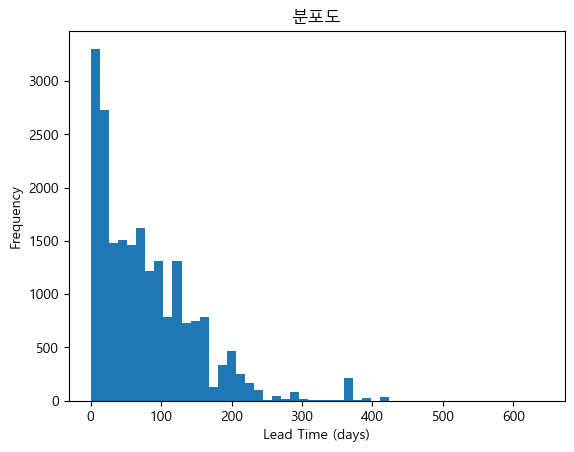

In [75]:
import matplotlib
import matplotlib.pyplot as plt
# 리드타임 값의 분포 확인

matplotlib.rcParams['font.family'] = 'Malgun Gothic'

plt.hist(y, bins=50)
plt.title('분포도')
plt.xlabel('Lead Time (days)')
plt.ylabel('Frequency')
plt.show()

In [78]:
# 리드타임이 1인 데이터를 필터링
lead_time_one = fdata[fdata['리드타임'] == 1]

# 리드타임이 1인 데이터 확인
print(f"리드타임이 1인 데이터 수: {len(lead_time_one)}")
print(lead_time_one[['발주', '창고입고', '리드타임']].head())


리드타임이 1인 데이터 수: 435
           발주       창고입고  리드타임
3  2019-04-01 2019-04-01   1.0
4  2019-04-01 2019-04-01   1.0
41 2019-02-08 2019-02-08   1.0
64 2019-04-01 2019-04-01   1.0
65 2019-04-01 2019-04-01   1.0


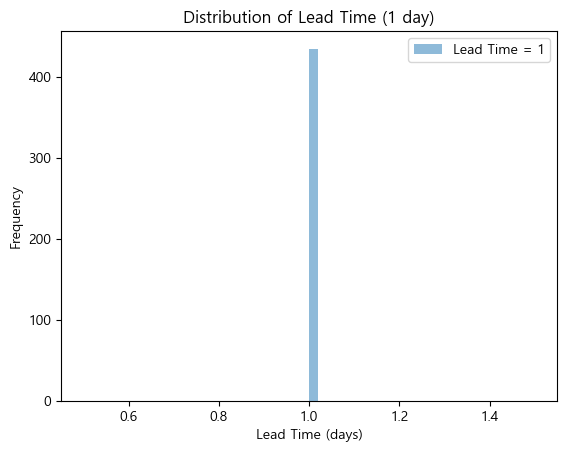

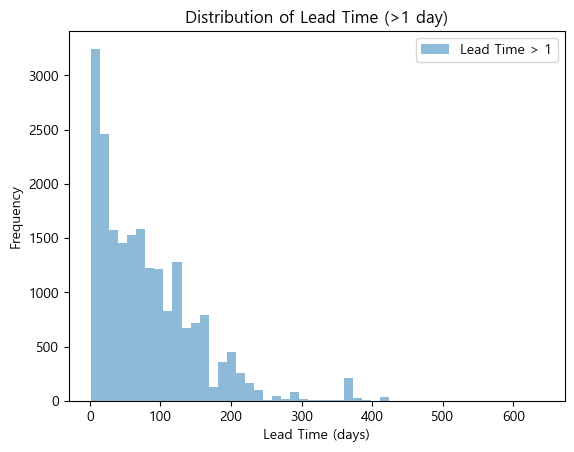

In [79]:
# 리드타임 1인 데이터 분포 시각화
plt.hist(lead_time_one['리드타임'], bins=50, alpha=0.5, label='Lead Time = 1')
plt.title('Distribution of Lead Time (1 day)')
plt.xlabel('Lead Time (days)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 리드타임 1이 아닌 데이터 시각화
lead_time_more_than_one = fdata[fdata['리드타임'] > 1]
plt.hist(lead_time_more_than_one['리드타임'], bins=50, alpha=0.5, label='Lead Time > 1')
plt.title('Distribution of Lead Time (>1 day)')
plt.xlabel('Lead Time (days)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

              발주       창고입고  리드타임
3     2019-04-01 2019-04-01   1.0
4     2019-04-01 2019-04-01   1.0
41    2019-02-08 2019-02-08   1.0
64    2019-04-01 2019-04-01   1.0
65    2019-04-01 2019-04-01   1.0
...          ...        ...   ...
24576 2022-03-25 2022-03-31   6.0
24577 2022-03-25 2022-03-31   6.0
24578 2022-03-25 2022-03-31   6.0
24579 2022-03-25 2022-03-31   6.0
24580 2022-03-25 2022-03-31   6.0

[2189 rows x 3 columns]
리드타임이 10일 이하인 데이터 수: 2189


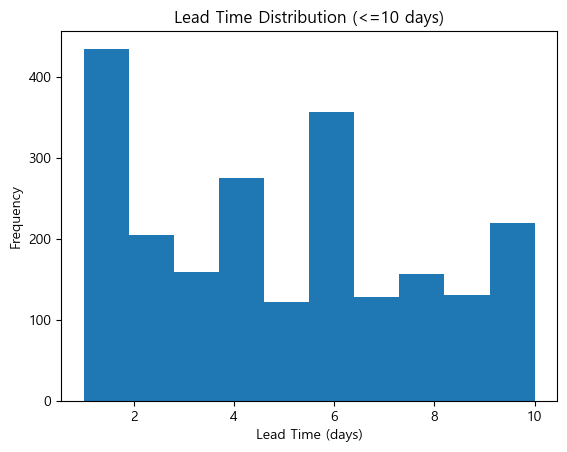

In [80]:
# 리드타임이 10일 이하인 값 확인
small_lead_times = fdata[fdata['리드타임'] <= 10]

# 리드타임이 작은 데이터 요약
print(small_lead_times[['발주', '창고입고', '리드타임']])
print(f"리드타임이 10일 이하인 데이터 수: {len(small_lead_times)}")

# 시각화
plt.hist(small_lead_times['리드타임'], bins=10)
plt.title('Lead Time Distribution (<=10 days)')
plt.xlabel('Lead Time (days)')
plt.ylabel('Frequency')
plt.show()

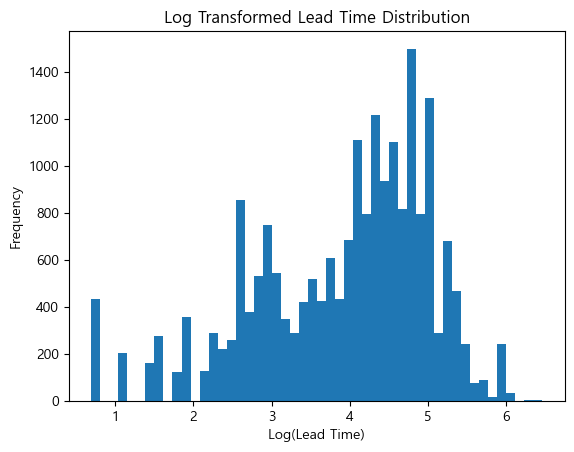

In [85]:
# 리드타임 로그 변환
fdata['log_리드타임'] = np.log1p(fdata['리드타임'])  # log(1+x)로 변환해 0값도 처리 가능

# 로그 변환 후 분포 시각화
plt.hist(fdata['log_리드타임'], bins=50)
plt.title('Log Transformed Lead Time Distribution')
plt.xlabel('Log(Lead Time)')
plt.ylabel('Frequency')
plt.show()


In [86]:
# 로그 변환된 리드타임으로 모델 학습
X = np.concatenate([embeddings.numpy(), currency_encoded], axis=1)
y = fdata['log_리드타임'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_regressor.fit(X_train, y_train)

# 예측 후 로그 변환을 다시 원래 값으로 되돌림
y_pred_log = xgb_regressor.predict(X_test)
y_pred = np.expm1(y_pred_log)  # exp(log(x+1)) - 1로 원래 값 복원

# 모델 성능 평가
print(f"XGBoost 테스트 데이터의 MSE (로그 변환 후): {mean_squared_error(np.expm1(y_test), y_pred)}")


XGBoost 테스트 데이터의 MSE (로그 변환 후): 3452.9250759349707
